## Create a Team of Agents to do Investment Analysis

![Graph](https://drive.google.com/uc?export=view&id=1xNZD0UabnSU5YJVuZtJ9-CQP6FdHPfYA)


This notebook draws inspiration from the paper [AutoGen: Enabling Next-Gen LLM Applications via Multi-Agent Conversation](https://arxiv.org/abs/2308.08155) by Wu et al., and the examples from [LangGraph](https://github.com/langchain-ai/langgraph/tree/main/examples/multi_agent). In this notebook, you will construct a Market Research Team and learn the following:

- How to define tools for agents. You will use the following tools:

  - [Exa](https://exa.ai/search), after account login, get your [API key here](https://docs.exa.ai/reference/getting-started-with-python). To find the exact content you're looking for on the web using embeddings-based search.  
  - [SerpApi here](https://serpapi.com/), after account login, get your [API key](https://serpapi.com/dashboard) to do look for existing patents.
  - [Python REPL](https://python.langchain.com/docs/integrations/tools/python/), please note that Python REPL can execute arbitrary code on the host machine (e.g., delete files, make network requests). Use with caution.
  - Tools to access and write to a `.txt` file and create a plot of historical prices.
- How to define utilities to help create the graph.
- How to create a team supervisor and the team of agents.


</br>

## LangGraph
You will be using [LangGraph](https://langchain-ai.github.io/langgraph/) for this. LangGraph is a library designed for building stateful, multi-actor applications with LLMs, facilitating the creation of agent and multi-agent workflows.

LangGraph supports the definition of flows that involve `cycles`, which are crucial for most __agentic architectures__. It is a low-level framework and provides you, therefore, fine-grained control over both the flow and state of your application.

LangGraph is inspired by [Pregel](https://research.google/pubs/pub37252/) and [Apache Beam](https://beam.apache.org/). The public interface draws inspiration from [NetworkX](https://networkx.org/documentation/latest/).

</br>

### Key Features

- __Cycles and Branching__: Implement loops and conditionals in your apps.
- __Persistence__: Automatically save state after each step in the graph. Pause and resume the graph execution at any point to support error recovery, human-in-the-loop workflows, time travel and more.
- __Human-in-the-Loop__: Interrupt graph execution to approve or edit next action planned by the agent.
- __Streaming Support__: Stream outputs as they are produced by each node (including token streaming).
- __Integration with LangChain__: LangGraph integrates seamlessly with [LangChain](https://www.langchain.com/) and [LangSmith](https://docs.smith.langchain.com/), but does not require them.

# Install Dependencies

In [1]:
!pip install -q langchain==0.2.12 \
                langgraph==0.1.19 \
                langchain_community==0.2.10 \
                langchain_experimental==0.0.63 \
                langchain_openai==0.1.20 \
                langchain_fireworks==0.1.7 \
                python-dotenv==1.0.1 \
                google-search-results==2.4.2 \
                exa-py==1.0.17

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 990.6/990.6 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.6/111.6 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.1/397.1 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.4/90.4 kB 5.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conf

# Imports

In [16]:
# Basic imports
import os
import functools
import operator
from tempfile import TemporaryDirectory
from pathlib import Path
from typing import Annotated, List, Dict, Optional
from typing_extensions import TypedDict
from exa_py import Exa
import json
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime



# LangChain & LangGraph imports
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_fireworks import ChatFireworks
from langchain.agents import AgentExecutor, create_openai_functions_agent
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_openai import ChatOpenAI
from langchain_openai.chat_models import ChatOpenAI
from langgraph.graph import END, StateGraph, START
from langchain_community.utilities import SerpAPIWrapper
from langchain_experimental.utilities import PythonREPL


# Display the graph
from IPython.display import Image, display

# API access
from dotenv import load_dotenv
load_dotenv()

True

# API Setup

In [17]:
# Setup .env file via the terminal
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
LANGCHAIN_API_KEY = os.getenv('LANGCHAIN_API_KEY')
TAVILY_API_KEY = os.getenv('TAVILY_API_KEY')
serp_api_key = os.getenv("SERPAPI_API_KEY")
exa_api_key = os.getenv("EXA_API_KEY")

# Uncomment if you want to use Fireworks instead of OpenAI
# FIREWORKS_API_KEY = os.getenv('FIREWORKS_API_KEY')

In [18]:
# Tracking via LangSmith
LANGCHAIN_API_KEY = os.getenv("LANGCHAIN_API_KEY")

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"


###### ATT ######
# The above API is for US-accounts, if you have an EU account you have use this one:
# os.environ["LANGCHAIN_ENDPOINT"] = "https://eu.api.smith.langchain.com/"


project_name = "Quant Minds Multi-Agents"  # Update with your project name
os.environ["LANGCHAIN_PROJECT"] = project_name  # Optional: "default" is used if not set


# Define a Persistent Working Directory

In [19]:
# Define a persistent working directory
WORKING_DIRECTORY = Path("/content/working_directory")

# Ensure the working directory exists
if not WORKING_DIRECTORY.exists():
    WORKING_DIRECTORY.mkdir(parents=True)
    print(f"Created working directory: {WORKING_DIRECTORY}")
else:
    print(f"Working directory already exists: {WORKING_DIRECTORY}")


Working directory already exists: /content/working_directory


# Create Tools

Here you will create the tools for your agents. You can extend your agents [toolbox](https://python.langchain.com/v0.2/docs/concepts/#tools) as you wish.
The `@tool` decorator is the simpliest way of defining a custom tool. Note that you __need__ to define a `docstring` as the tool's description.

</br>

__Note of caution__:

The document writing and file-access tools gives your agents access to your file-system, this can be unsafe. Also, the `PythonREPL()` executes your code locally, this can introduce risks if you are not sandboxing it.


In [20]:
########## Coding Tool ##########
repl = PythonREPL()
# Warning: This executes code locally, which can be unsafe when not sandboxed

@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

########## Websearch Tools ##########
@tool("finance_search")
def finance_search(query: str) -> str:
    """Search with Google SERP API by a query to Search Google for general
    information related to finance and stocks about a given topic."""
    params = {
        "engine": "google",
        "gl": "us",
        "hl": "en",
        }
    finance_search = SerpAPIWrapper(params=params, serpapi_api_key=serp_api_key)
    return finance_search.run(query)


@tool("exa_search")
def exa_search(question: str) -> str:
    """Tool using Exa's Python SDK to run semantic search and return result highlights."""
    exa = Exa(exa_api_key)

    response = exa.search_and_contents(
        question,
        type="neural",
        use_autoprompt=True,
        num_results=3,
        highlights=True
    )

    results = []
    for idx, eachResult in enumerate(response.results):
        result = {
            "Title": eachResult.title,
            "URL": eachResult.url,
            "Highlight": "".join(eachResult.highlights)
        }
        results.append(result)

    return json.dumps(results)


########## Analysis Tools ##########

def compute_tech_indicators(data, value):
    # Compute 10 and 30 days Moving Averages
    data['ma10'] = data[value].rolling(window=10).mean()
    data['ma30'] = data[value].rolling(window=30).mean()

    # Create MACD with shorter windows
    data['13ema'] = data[value].ewm(span=13).mean()
    data['6ema'] = data[value].ewm(span=6).mean()
    data['MACD'] = data['6ema'] - data['13ema']

    # Ensure `MACD` calculation is done before creating `MACD_Signal`
    data['MACD_Signal'] = create_MACD_signal(data['MACD'])

    # Create Exponential Moving Average (shorter window)
    data['ema'] = data[value].ewm(com=0.3).mean()

    # Create Momentum
    data['momentum'] = (data[value] / 100) - 1

    # RSI
    delta = data[value].diff()
    gain = delta.where(delta > 0, 0).rolling(window=7).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=7).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))

    return data

def create_MACD_signal(macd_series):
    macd_sign = np.sign(macd_series)
    macd_shifted_sign = macd_sign.shift(1)
    return macd_sign * (macd_sign != macd_shifted_sign)

def generate_MA_crossing(data, value, s_window=20, l_window=50):
    data['short_MA'] = data[value].rolling(window=s_window).mean()
    data['long_MA'] = data[value].rolling(window=l_window).mean()
    data['short_MA-long_MA'] = data['short_MA'] - data['long_MA']
    data['Signal'] = np.where(data['short_MA-long_MA'] > 0, 1, 0)
    data['Signal'] = np.where(data['short_MA-long_MA'] < 0, -1, data['Signal'])
    data['Trading'] = np.sign(data['Signal'] - data['Signal'].shift(1))
    return data


@tool("yf_fundamental_analysis")
def yf_fundamental_analysis(ticker: str):
    """
        Perform a comprehensive fundamental analysis on the given stock symbol {stock}.

        Args:
            stock_symbol (str): The stock symbol to analyze.

        Returns:
            dict: A dictionary with the detailed fundamental analysis results.
    """
    try:
        stock = yf.Ticker(ticker)
        info = stock.info

        # Data processing
        financials = stock.financials.infer_objects(copy=False)
        balance_sheet = stock.balance_sheet.infer_objects(copy=False)
        cash_flow = stock.cashflow.infer_objects(copy=False)

        # Fill missing values
        financials = financials.ffill()
        balance_sheet = balance_sheet.ffill()
        cash_flow = cash_flow.ffill()

        # Key Ratios and Metrics
        ratios = {
            "P/E Ratio": info.get('trailingPE'),
            "Forward P/E": info.get('forwardPE'),
            "P/B Ratio": info.get('priceToBook'),
            "P/S Ratio": info.get('priceToSalesTrailing12Months'),
            "PEG Ratio": info.get('pegRatio'),
            "Debt to Equity": info.get('debtToEquity'),
            "Current Ratio": info.get('currentRatio'),
            "Quick Ratio": info.get('quickRatio'),
            "ROE": info.get('returnOnEquity'),
            "ROA": info.get('returnOnAssets'),
            "ROIC": info.get('returnOnCapital'),
            "Gross Margin": info.get('grossMargins'),
            "Operating Margin": info.get('operatingMargins'),
            "Net Profit Margin": info.get('profitMargins'),
            "Dividend Yield": info.get('dividendYield'),
            "Payout Ratio": info.get('payoutRatio'),
        }

        # Growth Rates
        revenue = financials.loc['Total Revenue']
        net_income = financials.loc['Net Income']
        revenue_growth = revenue.pct_change(periods=-1).iloc[0] if len(revenue) > 1 else None
        net_income_growth = net_income.pct_change(periods=-1).iloc[0] if len(net_income) > 1 else None

        growth_rates = {
            "Revenue Growth (YoY)": revenue_growth,
            "Net Income Growth (YoY)": net_income_growth,
        }

        # Valuation
        market_cap = info.get('marketCap')
        enterprise_value = info.get('enterpriseValue')

        valuation = {
            "Market Cap": market_cap,
            "Enterprise Value": enterprise_value,
            "EV/EBITDA": info.get('enterpriseToEbitda'),
            "EV/Revenue": info.get('enterpriseToRevenue'),
        }

        # Future Estimates
        estimates = {
            "Next Year EPS Estimate": info.get('forwardEps'),
            "Next Year Revenue Estimate": info.get('revenueEstimates', {}).get('avg'),
            "Long-term Growth Rate": info.get('longTermPotentialGrowthRate'),
        }

        # Simple DCF Valuation (very basic)
        free_cash_flow = cash_flow.loc['Free Cash Flow'].iloc[0] if 'Free Cash Flow' in cash_flow.index else None
        wacc = 0.1  # Assumed Weighted Average Cost of Capital
        growth_rate = info.get('longTermPotentialGrowthRate', 0.03)

        def simple_dcf(fcf, growth_rate, wacc, years=5):
            if fcf is None or growth_rate is None:
                return None
            terminal_value = fcf * (1 + growth_rate) / (wacc - growth_rate)
            dcf_value = sum([fcf * (1 + growth_rate) ** i / (1 + wacc) ** i for i in range(1, years + 1)])
            dcf_value += terminal_value / (1 + wacc) ** years
            return dcf_value

        dcf_value = simple_dcf(free_cash_flow, growth_rate, wacc)

        # Prepare the results
        analysis = {
            "Company Name": info.get('longName'),
            "Sector": info.get('sector'),
            "Industry": info.get('industry'),
            "Key Ratios": ratios,
            "Growth Rates": growth_rates,
            "Valuation Metrics": valuation,
            "Future Estimates": estimates,
            "Simple DCF Valuation": dcf_value,
            "Last Updated": datetime.fromtimestamp(info.get('lastFiscalYearEnd', 0)).strftime('%Y-%m-%d'),
            "Data Retrieval Date": datetime.now().strftime('%Y-%m-%d'),
        }

        # Add interpretations
        interpretations = {
            "P/E Ratio": "High P/E might indicate overvaluation or high growth expectations" if ratios.get('P/E Ratio', 0) > 20 else "Low P/E might indicate undervaluation or low growth expectations",
            "Debt to Equity": "High leverage" if ratios.get('Debt to Equity', 0) > 2 else "Conservative capital structure",
            "ROE": "Strong returns" if ratios.get('ROE', 0) > 0.15 else "Potential profitability issues",
            "Revenue Growth": "Strong growth" if growth_rates.get('Revenue Growth (YoY)', 0) > 0.1 else "Slowing growth",
        }

        analysis["Interpretations"] = interpretations

        return analysis

    except Exception as e:
        return f"An error occurred during the analysis: {str(e)}"


@tool("yf_tech_analysis")
def yf_tech_analysis(stock_symbol: str, period: str = "1y"):
    """
        Perform a comprehensive technical analysis on the given stock symbol {stock}.

        Args:
            stock_symbol (str): The stock symbol to analyze.
            period (str, optional): The time period for analysis. Defaults to "1y".

        Returns:
            analysis_results_df: pandas dataframe, interpretation: dictionary
    """


    data = yf.download(stock_symbol, period=period)
    print("Initial data NaNs:\n", data.isna().sum())

    # Calculate indicators and diagnose NaNs
    data = compute_tech_indicators(data, 'Close')
    data = generate_MA_crossing(data, 'Close')

    # Forward-fill to handle NaNs due to rolling calculations
    data[['ma10', 'ma30', 'short_MA', 'long_MA']] = data[['ma10', 'ma30', 'short_MA', 'long_MA']].ffill()

    # Drop remaining rows with NaNs
    data = data.dropna()
    if data.empty:
        raise ValueError("Insufficient data after calculations. Increase the period or decrease indicator windows.")

    # Create DataFrame for `analysis_results`
    analysis_results_df = pd.DataFrame({
        'Current_Price': [data['Close'].iloc[-1]],
        '10_MA': [data['ma10'].iloc[-1]],
        '30_MA': [data['ma30'].iloc[-1]],
        'Short_MA': [data['short_MA'].iloc[-1]],
        'Long_MA': [data['long_MA'].iloc[-1]],
        '6_EMA': [data['6ema'].iloc[-1]],
        '13_EMA': [data['13ema'].iloc[-1]],
        'EMA': [data['ema'].iloc[-1]],
        'MACD_Value': [data['MACD'].iloc[-1]],
        'MACD_Signal': [data['MACD_Signal'].iloc[-1]],
        'RSI': [data['RSI'].iloc[-1]],
        'Momentum': [data['momentum'].iloc[-1]],
        'MA_Crossing_Signal': [data['Signal'].iloc[-1]],
        'Trading_Action': [data['Trading'].iloc[-1]]
    })

    # Convert the last values to scalars to avoid ambiguity
    latest_close = data['Close'].iloc[-1].item() if hasattr(data['Close'].iloc[-1], 'item') else data['Close'].iloc[-1]
    latest_ma30 = data['ma30'].iloc[-1].item() if hasattr(data['ma30'].iloc[-1], 'item') else data['ma30'].iloc[-1]
    latest_macd = data['MACD'].iloc[-1].item() if hasattr(data['MACD'].iloc[-1], 'item') else data['MACD'].iloc[-1]
    latest_rsi = data['RSI'].iloc[-1].item() if hasattr(data['RSI'].iloc[-1], 'item') else data['RSI'].iloc[-1]

    # Interpretation
    interpretation = {
        'Trend': 'Bullish' if latest_close > latest_ma30 else 'Bearish',
        'RSI': 'Overbought' if latest_rsi > 70 else ('Oversold' if latest_rsi < 30 else 'Neutral'),
        'MACD': 'Bullish' if latest_macd > 0 else 'Bearish'
    }

    return analysis_results_df, interpretation


########## Document Tools ##########
@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


@tool
def read_document(
    file_name: Annotated[str, "File path to save the document."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is not None:
        start = 0
    return "\n".join(lines[start:end])


@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"


@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ],
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"


# Create Agent and Team Supervisor

In [21]:
def create_agent(
    llm: ChatOpenAI,
    tools: list,
    system_prompt: str,
) -> str:
    """Create a function-calling agent and add it to the graph."""
    system_prompt += "\nWork autonomously according to your specialty, using the tools available to you."
    " Do not ask for clarification."
    " Your other team members (and other teams) will collaborate with you with their own specialties."
    " You are chosen for a reason! You are one of the following team members: {team_members}."
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_functions_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools, handle_parsing_errors=True)
    return executor


def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}


def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
    """An LLM-based router."""
    options = ["FINISH"] + members
    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
            },
            "required": ["next"],
        },
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    return (
        prompt
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )

# Create the Agents and Graph

Here you create the agents you can also combine different LLMs to do your tasks. This might be beneficial because for specific tasks some LLMs might perform better than others or be less costly than others.

First you have to define the `graph state`. And then you can create your agents which can access the tools created before.

**State**: A shared data structure that represents the current snapshot of an application. It can be any Python type, but is typically a TypedDict or Pydantic BaseModel.


## Define Graph State

In [22]:
# Define team graph state
class FinanceTeamState(TypedDict):
    # This tracks the team's conversation internally
    messages: Annotated[List[BaseMessage], operator.add]
    # This provides each worker with context on the others' skill sets
    team_members: str
    # This is how the supervisor tells langgraph who has to work next
    next: str
    # This tracks the shared directory state
    current_files: str

Next, you have a helper function that will run before each worker agent begins their task. This function ensures that the agents are more aware of the current state of the working directory.


## Helper Function for Dictory Access

In [23]:
def prelude(state):
    """
    A helper function that prepares the state for each worker agent by ensuring the working directory exists
    and listing the files present in it.

    Args:
        state (dict): The current state to be updated with information about the files in the working directory.

    Returns:
        dict: The updated state with a key "current_files" containing a message about the files in the directory.
              If no files are present, the message will indicate that no files have been written.
    """

    written_files = []
    if not WORKING_DIRECTORY.exists():
        WORKING_DIRECTORY.mkdir(parents=True)
    try:
        written_files = [
            f.relative_to(WORKING_DIRECTORY) for f in WORKING_DIRECTORY.rglob("*")
            if f.is_file()
        ]
    except Exception as e:
        print(f"Error reading files: {e}")
    if not written_files:
        return {**state, "current_files": "No files written."}
    return {
        **state,
        "current_files": "\nBelow are files your team has written to the directory:\n"
        + "\n".join([f" - {f}" for f in written_files]),
    }

# Init LLM

Now you can initialize your LLM. You can also use another LLM, for instance via [Fireworks](https://fireworks.ai/) works seemlessly with this LangGraph setting instead of OpenAI. For this, you just need to get the API key and if you want to use, for instance, the `Llama 3.1 70B` model, you how have to initialize your LLM as follows:

```python
from langchain_fireworks import ChatFireworks

llm = ChatFireworks(
    model="accounts/fireworks/models/llama-v3p1-70b-instruct",
    temperature=0
)


In [24]:
######## Initialize the LLM ########
llm = ChatOpenAI(model="gpt-4o")

# Define the Agents

__ATT:__ We to escape the curly braces, that is, we have to wrap the placeholder in double curly braces `{{Stock}}` so it’s not mistaken for a variable in ChatPromptTemplate. With this, the stock will be treated as part of the prompt text rather than requiring an actual variable input.

In [30]:
exa_search_agent = create_agent(
    llm,
    [exa_search],
    """As a seasoned investment strategist with 20 years of experience, you weave
    complex financial data into compelling investment narratives,
    your response should clearly articulate the key points you found on {{stock_symbol}} and this {{date}}.""",
)
exa_search_node = functools.partial(agent_node, agent=exa_search_agent, name="ExaSearch")


finance_search_agent = create_agent(
    llm,
    [finance_search],
    """As a seasoned investment strategist with 20 years of experience, you weave
    complex financial data into compelling investment narratives on {{stock_symbol}} and this {{date}}.""",
)
finance_search_node = functools.partial(agent_node, agent=finance_search_agent, name="FinanceSearch")


fundamental_analysis_agent = create_agent(
    llm,
    [yf_fundamental_analysis],
    """With a CFA charter and over 20 years of experience in investing,
    you dissect financial statements and identify key value drivers on {{stock_symbol}} and this {{date}}.""",
)
fundamental_analysis_node = functools.partial(agent_node, agent=fundamental_analysis_agent, name="FinanceAnalysis")

tech_analysis_agent = create_agent(
    llm,
    [yf_tech_analysis],
    """You are Chartered Market Technician (CMT) with 25 years of experience,
    you have a keen eye for market trends and patterns on {{stock_symbol}} and this {{date}}.""",
)
tech_analysis_node = functools.partial(agent_node, agent=tech_analysis_agent, name="TechnicalAnalysis")


chart_agent = create_agent(
    llm,
    [python_repl],
    """You are a Quant Developer and can write code to plot any charts requested.""",
)
chart_node = functools.partial(agent_node, agent=chart_agent, name="ChartGenerator")

doc_writer_agent = create_agent(
    llm,
    [write_document, edit_document, read_document],
    """You are a Chief Investment Strategist, who synthesize all analyses to create
    a definitive investment report on {{stock_symbol}}.
    \n""",
)

# Injects current directory working state before each call
context_aware_doc_writer_agent = prelude | doc_writer_agent
doc_writing_node = functools.partial(
    agent_node, agent=context_aware_doc_writer_agent, name="DocWriter"
)

investment_analysis_supervisor = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {team_members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["DocWriter", "ExaSearch", "FinanceSearch", "FinanceAnalysis", "TechnicalAnalysis", "ChartGenerator" ,"DocWriter"],
)

## Create the Graph

- **Nodes**: Functions that encode the logic of the agents. They receive the current state as input, perform some computation or side-effect, and return an updated state.
- **Edges**: Functions that determine which node to execute next based on the current state. They can be conditional branches or fixed transitions.

In [31]:
# Create the graph
financial_graph = StateGraph(FinanceTeamState)
financial_graph.add_node("DocWriter", doc_writing_node)
financial_graph.add_node("ExaSearch", exa_search_node)
financial_graph.add_node("FinanceSearch", finance_search_node)
financial_graph.add_node("FinanceAnalysis", fundamental_analysis_node)
financial_graph.add_node("TechnicalAnalysis", tech_analysis_node)
financial_graph.add_node("ChartGenerator", chart_node)
financial_graph.add_node("supervisor", investment_analysis_supervisor)

# Add the edges
financial_graph.add_edge("DocWriter", "supervisor")
financial_graph.add_edge("ExaSearch", "supervisor")
financial_graph.add_edge("FinanceSearch", "supervisor")
financial_graph.add_edge("FinanceAnalysis", "supervisor")
financial_graph.add_edge("ChartGenerator", "supervisor")
financial_graph.add_edge("TechnicalAnalysis", "supervisor")

# Add the edges where routing applies
financial_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "DocWriter": "DocWriter",
        "FinanceSearch": "FinanceSearch",
        "FinanceAnalysis": "FinanceAnalysis",
        "TechnicalAnalysis": "TechnicalAnalysis",
        "ChartGenerator": "ChartGenerator",
        "ExaSearch": "ExaSearch",
        "FINISH": END,
    },
)

financial_graph.add_edge(START, "supervisor")
chain = financial_graph.compile()


# The following functions interoperate between the top level graph state
# and the state of the research sub-graph
# this makes it so that the states of each graph don't get intermixed
def enter_chain(message: str, members: List[str]):
    results = {
        "messages": [HumanMessage(content=message)],
        "team_members": ", ".join(members),
    }
    return results

financial_chain = (
    functools.partial(enter_chain, members=financial_graph.nodes)
    | financial_graph.compile()
)


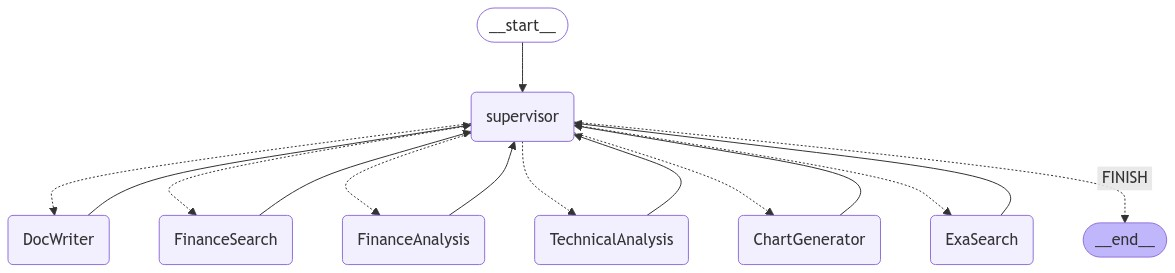

In [32]:
display(Image(chain.get_graph().draw_mermaid_png()))

{'supervisor': {'next': 'FinanceSearch'}}
---
{'FinanceSearch': {'messages': [HumanMessage(content="### Investment Report on Tesla (TSLA) - November 15th, 2024\n\n#### Technical Analysis\n\nAs of November 2024, Tesla's stock (TSLA) has demonstrated significant volatility. Following the US elections, Tesla's stock surged nearly 25% but has recently dipped into correction territory. Technical indicators suggest that the stock is experiencing resistance around its recent highs. The correction phase may be indicative of profit-taking by investors after the substantial rally. \n\nKey technical levels to watch include:\n- **Support Level:** Around $250, a historical support zone that could attract buyers if the price continues to decline.\n- **Resistance Level:** Approximately $300, which was tested during the post-election rally but failed to sustain.\n\nThe Relative Strength Index (RSI) has moved from overbought levels back towards neutral territory, suggesting that the recent selling pres

[*********************100%***********************]  1 of 1 completed


Initial data NaNs:
 Price      Ticker
Adj Close  TSLA      0
Close      TSLA      0
High       TSLA      0
Low        TSLA      0
Open       TSLA      0
Volume     TSLA      0
dtype: int64
{'TechnicalAnalysis': {'messages': [HumanMessage(content="### Investment Report on Tesla (TSLA) - November 15th, 2024\n\n#### Technical Analysis\n\nTesla's stock (TSLA) is currently priced at approximately $316.16. Over the past year, the stock has shown a bullish trend, supported by the following technical indicators:\n\n- **Moving Averages:**\n  - **10-Day Moving Average:** $303.70\n  - **30-Day Moving Average:** $259.34\n  - **Short MA (50-Day):** $274.78\n  - **Long MA (200-Day):** $252.20\n\nThe moving averages indicate a bullish crossover, with the short-term moving averages positioned above the long-term averages.\n\n- **Exponential Moving Averages:**\n  - **6-Day EMA:** $315.27\n  - **13-Day EMA:** $298.27\n  - Current EMA suggests continued upward momentum.\n\n- **MACD (Moving Average Conver

[*********************100%***********************]  1 of 1 completed


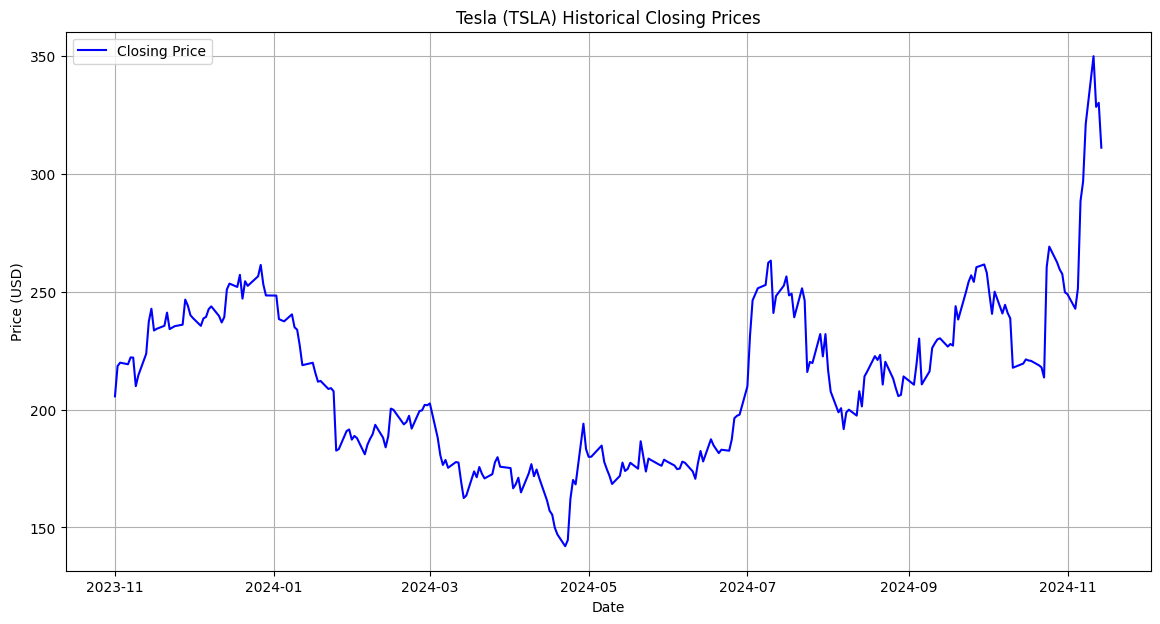

{'ChartGenerator': {'messages': [HumanMessage(content='The investment report for Tesla (TSLA) as of November 15th, 2024, has been successfully generated and includes both technical and fundamental analysis, along with a historical price line graph. The report has been saved as a text file named `Tesla_Investment_Report_2024.txt`.\n\nTo view the report or the graph, you can access the respective files on your system:\n\n- **Investment Report:** `Tesla_Investment_Report_2024.txt`\n- **Historical Price Graph:** `Tesla_Historical_Price_2024.png`', name='ChartGenerator')]}}
---
{'supervisor': {'next': 'DocWriter'}}
---
{'DocWriter': {'messages': [HumanMessage(content='The investment report on Tesla (TSLA) as of November 15th, 2024, has been successfully written and saved as `Tesla_Investment_Report_2024.txt`. This report includes both technical and fundamental analysis, along with insights into the historical price trends of Tesla stock. You can access and review it on your system.', name='

<Figure size 640x480 with 0 Axes>

In [33]:
for s in financial_chain.stream(
    """Write an investment report on {{TESLA}} stock for this {{November, 15th 2024}}. Do a technical analysis and
    a fundamental anaylsis on {{TESLA}}. Also draw a line graph of it the historical price on {{TESLA}}. After that, write all into an investment
    report and save it to disk as .txt file.""",
    {"recursion_limit": 100},
):
    if "__end__" not in s:
        print(s)
        print("---")


# Result Report

### Tesla Stock Investment Report - November 15, 2024

#### Overview

Tesla, Inc. (TSLA) has been experiencing significant market movements recently, driven by both external economic factors and internal company dynamics. This report provides an in-depth analysis of Tesla's stock, focusing on both technical and fundamental aspects.

#### Technical Analysis

1. **Current Price**: As of November 14, 2024, Tesla's stock price is approximately \$311.18.

2. **Moving Averages**:
   - 10-day Moving Average: \$296.98
   - 30-day Moving Average: \$257.14
   - Short-term Moving Average: \$270.00
   - Long-term Moving Average: \$250.09

   Tesla is trading above its short-term and long-term moving averages, indicating a bullish trend.

3. **Exponential Moving Averages (EMA)**:
   - 6-day EMA: \$314.92
   - 13-day EMA: \$295.29
   - Overall EMA: \$315.65

4. **MACD (Moving Average Convergence Divergence)**:
   - MACD Value: 19.63
   - Signal Line: 0.0

   The MACD indicator is bullish, suggesting positive momentum in the stock price.

5. **Relative Strength Index (RSI)**: 71.20
   - The RSI indicates overbought conditions, which could lead to a short-term pullback.

6. **Momentum**: 2.11
   - Positive momentum supports the bullish trend.

7. **MA Crossing Signal**: 1
   - Indicates a bullish crossover of moving averages.

8. **Trading Action**: Hold
   - Based on the technical indicators, the recommendation is to hold the stock.

#### Fundamental Analysis

1. **Revenue and Profitability**: Tesla continues to exhibit strong revenue growth fueled by its expanding electric vehicle and energy solutions market. However, profit margins face pressure due to increased competition and rising production costs.

2. **Strategic Developments**: The recent political landscape, including potential changes to EV tax credits, poses challenges for Tesla's domestic sales growth. Nevertheless, its international expansion, particularly in Asia and Europe, could mitigate these risks.

3. **Leadership and Innovation**: Elon Musk's visionary leadership continues to drive Tesla's innovation, though his controversial public statements can lead to market volatility.

4. **Market Position**: Tesla's strong brand and technological leadership remain crucial in maintaining its dominance in the EV market, despite growing competition from traditional automakers.

5. **Valuation**: Tesla's elevated price-to-earnings (P/E) ratio reflects high investor expectations, implying risk if growth projections are not met.

#### Historical Price Analysis

The historical price movement of Tesla has been characterized by high volatility and strong rallies. Below is a line graph illustrating Tesla's historical price over the past year.

![Tesla Historical Price](https://drive.google.com/uc?export=view&id=1uDCKLI6XUmTt0JWtbxA1yfdtRw_mQqh6)


### Conclusion and Recommendation

Tesla represents a high-risk, high-reward investment opportunity. The stock's current bullish trend, coupled with its leadership in the EV sector, makes it attractive for investors with a high-risk tolerance and a long-term perspective. However, those seeking more stability should consider waiting for a more favorable entry point or clearer evidence of sustained growth.

**Investment Rating**: Hold

---

This report is intended for informational purposes and should not be considered investment advice. Investors are encouraged to conduct their own research or consult with a financial advisor before making investment decisions.